In [1]:
import torch
import torch.nn.functional as F
import torchvision
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import subprocess as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import pickle

## Config

In [2]:
SEARCH_BS = False
# SEARCH_BS = True
SEARCH_LR = False
# SEARCH_LR = True

In [3]:
# Resize images
resize_img = 1300
resize_img = int(32*int(resize_img/32))

# Batch size
BS_train = 4
if SEARCH_LR:
    BS_train = int(BS_train / 4)
    if BS_train == 0:
        BS_train = 1
BS_val = BS_train * 4

# Train
EPOCHS = 400
# EPOCHS = 3
LR = 1e-2

# Save best model
NOTEBOOK_NAME = '09_Resnet50_smp'

# Dataset split
VALID_SPLIT = 0.2

# Model
number_of_classes = 2 # 2 classes
number_of_channels = 3
encoder_name = 'resnet50'
encoder_weights = 'imagenet'
activation = None
name_best_model = f'{NOTEBOOK_NAME}_best_model.pth'
name_early_stopping_model = f'{NOTEBOOK_NAME}_early_stopping.pth'
name_final_model = f'{NOTEBOOK_NAME}_final_model.pth'
path_to_save_models = path = Path("../models/")
path_best_model = path_to_save_models / name_best_model
path_early_stopping_model = path_to_save_models / name_early_stopping_model
path_final_model = path_to_save_models / name_final_model

# Learning rate decay
LE_DECAY_FACTOR = 0.1
LE_DECAY_PATIENCE = 10

# Early stopping
EARLY_STOPPING = False
EARLY_STOPPING_PATIENCE = 30

# Epochs when model can be saved
MIN_SAVE_EPOCHS = 10

## Dataframe

In [4]:
path = Path("../")
data_path = path / "data"
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv',
 'submission.csv']

In [5]:
train_images_path = data_path / "train_images"

In [6]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## Dice coefficient loss

In [7]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

## Dataset and Dataloader

In [8]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [9]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    # Get image path from column 'path' in dataframe
    img_path = str(self.dataframe.iloc[ix]['path'])
    # Load image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    # Resize image
    img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # Normalize image
    img_cv_res_norm = img_cv_res / 255.0
    # Convert to tensor
    img_tensor = torch.from_numpy(img_cv_res_norm).float().permute(2, 0, 1)

    # Get mask
    rle = self.dataframe.iloc[ix]['rle']
    mask_cv = rle2mask(rle, img_cv.shape)
    # Resize mask
    mask_cv_res = cv2.resize(mask_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # One-hot encode mask
    mask_oh = np.eye(2)[mask_cv_res.astype(int)].astype(np.float32)
    # Convert to tensor
    mask_tensor = torch.from_numpy(mask_oh).float().permute(2, 0, 1)
    
    return img_tensor, mask_tensor

In [10]:
train_split, val_split = train_test_split(train_df, test_size=VALID_SPLIT, shuffle=True, random_state=42, stratify=train_df['organ'])
dataset = {
    'train': Dataset(train_split, n_classes=2, dim=resize_img),
    'val': Dataset(val_split, n_classes=2, dim=resize_img),
}

print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 280 imágenes de entrenamiento y 71 imágenes de validación


In [11]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
}

## Model initialization

In [12]:
def model_init():
    model = smp.Unet(encoder_name, encoder_weights=encoder_weights, in_channels=number_of_channels, classes=number_of_classes, activation=activation)
    return model

## Batch size finder

In [13]:
if SEARCH_BS:
    model = model_init()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    if torch.cuda.is_available():
        if torch.cuda.device_count() >= 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = torch.nn.DataParallel(model)
        else:
            model.cuda()
    else:
        print("Using CPU")

In [14]:
if SEARCH_BS:
    LR = 1e-3
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

In [15]:
if SEARCH_BS:
    def train_loop(dataloader, model, loss_fn, optimizer):
        model.train()
        for (imgs, masks) in dataloader:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [16]:
if SEARCH_BS:
    def list_of_posible_batch_sizes(dataset):
        batch_sizes = []
        batch_size = 1
        while batch_size < 2*len(dataset):
            batch_sizes.append(batch_size)
            batch_size *= 2
        batch_sizes.sort(reverse=True)
        return batch_sizes

    BSs = list_of_posible_batch_sizes(dataset['train'])
    print(BSs)

In [17]:
if SEARCH_BS:
    for batchsize_train in BSs:
        print(f"batch size: {batchsize_train}")
        train_dl = torch.utils.data.DataLoader(dataset['train'], batch_size=batchsize_train, shuffle=True, pin_memory=True)
        epochs = 3
        out_of_memory = False
        for t in range(epochs):
            print(f"\tTrain epoch {t} of {epochs}")
            try:
                train_loop(train_dl, model, optimizer, optimizer)
            except Exception as e:
                if "CUDA out of memory" in str(e):
                    position = str(e).index('CUDA out of memory')
                    print(f"\t{str(e)[position:]}")
                    out_of_memory = True
                    break
                else:
                    out_of_memory = False
                break
        if out_of_memory == False:
            break
        print()
    print(f"Done!, bacth size is {batchsize_train}")

In [18]:
if SEARCH_BS:
    BS_train = batchsize_train
    BS_val = BS_train * 4
    print(f"For {resize_img}x{resize_img} images size, we use batch size of {BS_train} for train and batch size of {BS_val} for validation")

## Search LR

In [19]:
if SEARCH_LR:
    def lr_finder(model, train_dl, loss_fn, device, lr_init=1e-8, lr_end=10, increment=4, beta=0.98):
        num = len(train_dl)-1 # Numero de lrs que vamos a probar
        q = (lr_end/lr_init)**(1/num) # Incremento de lr
        lr = lr_init
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss = 0
        best_loss = 0.
        avg_loss = 0.
        smoothed_avg_losses = []
        lrs = []
        for batch, (imgs, masks) in enumerate(train_dl):
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Update optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            avg_loss = beta * avg_loss + (1-beta) * loss.to("cpu").item()
            smoothed_loss = avg_loss / (1 - beta**(batch+1))
            if increment is not None:
                # Se para si el loss se dispara
                window = 10
                if batch > window and smoothed_avg_losses[-window] > increment * best_loss:
                    return lrs, smoothed_avg_losses
            
            # Se guarda la menor pérdida
            if avg_loss < best_loss or batch==0:
                best_loss = smoothed_loss
            
            # Se guardan los datos
            smoothed_avg_losses.append(smoothed_loss)
            lrs.append(lr)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update lr
            lr *= q

        return lrs, smoothed_avg_losses

In [20]:
if SEARCH_LR:
    model = model_init()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    [lrss, smoothed_avg_losses] = lr_finder(model, train_dl=dataloader['train'], loss_fn = criterion, device=device)

    plt.plot(lrss, smoothed_avg_losses)
    plt.xlabel("lr")
    plt.ylabel("loss")
    plt.xscale("log")
    plt.grid()
    plt.show()

In [21]:
if SEARCH_LR:
    LR = 1e-2

## Train all images

In [22]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_loop(dataloader, model, loss_fn, optimizer, bar, hist, device):
    train_loss, train_dice = [], []
    model.train()
    # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
    for imgs, masks in bar:
        # X and y to device
        imgs, masks = imgs.to(device), masks.to(device)
        # Compute prediction and loss
        pred_mask = model(imgs)
        loss = loss_fn(pred_mask, masks)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update train loss and dice
        dice = dice_coeff(pred_mask, masks)
        train_loss.append(loss.item())
        train_dice.append(dice)
        # Update progress bar
        bar.set_description(f"\t\tloss {np.mean(train_loss):.5f}, dice {np.mean(train_dice):.5f}")
    hist['loss'].append(np.mean(train_loss))
    hist['dice'].append(np.mean(train_dice))
    return hist

def valid_loop(dataloader, model, loss_fn, optimizer, bar, hist, device):
    val_loss, val_dice = [], []
    model.eval()
    with torch.no_grad():
        # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
        for imgs, masks in bar:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)
            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            # Update test loss and dice
            dice = dice_coeff(pred_mask, masks)
            val_loss.append(loss.item())
            val_dice.append(dice)
            # Update progress bar
            bar.set_description(f"\t\tval_loss {np.mean(val_loss):.5f} val_dice {np.mean(val_dice):.5f}")
    hist['val_loss'].append(np.mean(val_loss))
    hist['val_dice'].append(np.mean(val_dice))
    return hist

def fit(model, dataloader, device, epochs=100, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()
    best_dice = 0.
    early_stop_counter = 0
    schedulerOnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=LE_DECAY_FACTOR, patience=LE_DECAY_PATIENCE, verbose=True)
    if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        if parallel:
            model = torch.nn.DataParallel(model)
        model.cuda()
    else:
        print("Let's use CPU!")
        model.to(device)
    hist = {'loss': [], 'dice': [], 'val_loss': [], 'val_dice': []}
    for epoch in range(epochs):
        # Train
        bar = tqdm(dataloader['train'])
        hist = train_loop(dataloader, model, criterion, optimizer, bar, hist, device)

        # Validation
        bar = tqdm(dataloader['val'])
        hist = valid_loop(dataloader, model, criterion, optimizer, bar, hist, device)
        
        # Print epoch results
        if len_int_epochs == 1:
            print(f"Epoch {(epoch+1):01d}/{epochs:01d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 2:
            print(f"Epoch {(epoch+1):02d}/{epochs:02d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 3:
            print(f"Epoch {(epoch+1):03d}/{epochs:03d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 4:
            print(f"Epoch {(epoch+1):04d}/{epochs:04d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")

        # Save model if best dice
        if hist['val_dice'][-1] > best_dice and epoch >= MIN_SAVE_EPOCHS:
            best_dice = hist['val_dice'][-1]
            torch.save(model, path_best_model)
            print(f"New best dice: {best_dice:.5f}, model saved to {path_best_model}")
        
        # Update scheduler
        schedulerOnPlateau.step(hist['val_loss'][-1])

        # Early stopping
        if hist['val_dice'][-1] < best_dice:
            early_stop_counter += 1
            if early_stop_counter == EARLY_STOPPING_PATIENCE+1:
                torch.save(model, path_early_stopping_model)
                print(f"Early stopping at epoch {epoch+1}")
                print(f"Early stopping dice: {hist['val_dice'][-1]}, model saved to {path_early_stopping_model}")
                if EARLY_STOPPING:
                    break
        else:
            early_stop_counter = 0
        
    # Save final model
    torch.save(model, path_final_model)
    print(f"Final model dice: {hist['val_dice'][-1]}, saved to {path_final_model}")
    
    return hist

In [23]:
if not SEARCH_BS and not SEARCH_LR:
    model = model_init()
    hist = fit(model, dataloader, device, epochs=EPOCHS, lr=LR, parallel=True)

Let's use 2 GPUs!


		val_loss 0.42820 val_dice 1.47622: 100%|██████████| 5/5 [00:12<00:00,  2.42s/it]


Epoch 001/400 loss 0.28901 dice 6.81683 val_loss 0.42820 val_dice 1.47622


		val_loss 0.31159 val_dice 6.21394: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Epoch 002/400 loss 0.24919 dice 7.64170 val_loss 0.31159 val_dice 6.21394


		val_loss 0.28801 val_dice 6.93689: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


Epoch 003/400 loss 0.24685 dice 7.64261 val_loss 0.28801 val_dice 6.93689


		val_loss 0.37902 val_dice 9.10557: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Epoch 004/400 loss 0.23848 dice 7.56028 val_loss 0.37902 val_dice 9.10557


		val_loss 0.32401 val_dice 7.82961: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Epoch 005/400 loss 0.23977 dice 7.59738 val_loss 0.32401 val_dice 7.82961


		val_loss 0.29101 val_dice 5.38335: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Epoch 006/400 loss 0.22796 dice 8.33291 val_loss 0.29101 val_dice 5.38335


		val_loss 0.52991 val_dice 1.22678: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Epoch 007/400 loss 0.22955 dice 8.18733 val_loss 0.52991 val_dice 1.22678


		val_loss 0.29938 val_dice 6.00879: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Epoch 008/400 loss 0.23110 dice 8.50482 val_loss 0.29938 val_dice 6.00879


		val_loss 0.27451 val_dice 5.79690: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Epoch 009/400 loss 0.22641 dice 7.91695 val_loss 0.27451 val_dice 5.79690


		val_loss 0.26523 val_dice 7.39272: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Epoch 010/400 loss 0.22446 dice 8.33003 val_loss 0.26523 val_dice 7.39272


		val_loss 0.27106 val_dice 6.87098: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


Epoch 011/400 loss 0.21439 dice 8.64637 val_loss 0.27106 val_dice 6.87098
New best dice: 6.87098, model saved to ../models/09_Resnet50_smp_best_model.pth


		val_loss 0.27737 val_dice 6.15336: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Epoch 012/400 loss 0.22631 dice 8.22089 val_loss 0.27737 val_dice 6.15336


		val_loss 0.30846 val_dice 9.84710: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Epoch 013/400 loss 0.21885 dice 9.04375 val_loss 0.30846 val_dice 9.84710
New best dice: 9.84710, model saved to ../models/09_Resnet50_smp_best_model.pth


		val_loss 0.29480 val_dice 8.23697: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Epoch 014/400 loss 0.21939 dice 8.55092 val_loss 0.29480 val_dice 8.23697


		val_loss 0.39913 val_dice 3.26486: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Epoch 015/400 loss 0.21022 dice 9.12823 val_loss 0.39913 val_dice 3.26486


		val_loss 0.42087 val_dice 3.75771: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Epoch 016/400 loss 0.21492 dice 8.68601 val_loss 0.42087 val_dice 3.75771


		val_loss 0.26036 val_dice 9.07905: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Epoch 017/400 loss 0.21444 dice 8.83141 val_loss 0.26036 val_dice 9.07905


		val_loss 0.26377 val_dice 8.57143: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 018/400 loss 0.21195 dice 9.21140 val_loss 0.26377 val_dice 8.57143
Epoch 00018: reducing learning rate of group 0 to 1.0000e-03.


		val_loss 0.24302 val_dice 7.89183: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 019/400 loss 0.19775 dice 8.56554 val_loss 0.24302 val_dice 7.89183


		val_loss 0.22836 val_dice 8.99757: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 020/400 loss 0.19005 dice 8.95148 val_loss 0.22836 val_dice 8.99757


		val_loss 0.31955 val_dice 5.79568: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 021/400 loss 0.19171 dice 9.32094 val_loss 0.31955 val_dice 5.79568


		val_loss 0.26056 val_dice 9.60761: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 022/400 loss 0.18511 dice 9.29221 val_loss 0.26056 val_dice 9.60761


		val_loss 0.22162 val_dice 8.01211: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 023/400 loss 0.18804 dice 9.41978 val_loss 0.22162 val_dice 8.01211


		val_loss 0.25785 val_dice 7.74407: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 024/400 loss 0.18771 dice 9.43847 val_loss 0.25785 val_dice 7.74407


		val_loss 0.27554 val_dice 9.14517: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 025/400 loss 0.18125 dice 9.58716 val_loss 0.27554 val_dice 9.14517


		val_loss 0.22109 val_dice 9.68646: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 026/400 loss 0.18016 dice 9.74216 val_loss 0.22109 val_dice 9.68646


		val_loss 0.24149 val_dice 9.77916: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 027/400 loss 0.18255 dice 9.62111 val_loss 0.24149 val_dice 9.77916


		val_loss 0.34240 val_dice 10.74726: 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]


Epoch 028/400 loss 0.18282 dice 9.68126 val_loss 0.34240 val_dice 10.74726
New best dice: 10.74726, model saved to ../models/09_Resnet50_smp_best_model.pth


		val_loss 0.21159 val_dice 8.06068: 100%|██████████| 5/5 [00:11<00:00,  2.40s/it]


Epoch 029/400 loss 0.18251 dice 9.69325 val_loss 0.21159 val_dice 8.06068
Epoch 00029: reducing learning rate of group 0 to 1.0000e-04.


		val_loss 0.21363 val_dice 9.61461: 100%|██████████| 5/5 [00:11<00:00,  2.36s/it]


Epoch 030/400 loss 0.17636 dice 9.73256 val_loss 0.21363 val_dice 9.61461


		val_loss 0.20690 val_dice 9.83450: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Epoch 031/400 loss 0.17677 dice 9.79868 val_loss 0.20690 val_dice 9.83450


		val_loss 0.20666 val_dice 10.28689: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Epoch 032/400 loss 0.17519 dice 9.83354 val_loss 0.20666 val_dice 10.28689


		val_loss 0.20377 val_dice 9.48349: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


Epoch 033/400 loss 0.17893 dice 9.82031 val_loss 0.20377 val_dice 9.48349


		val_loss 0.20450 val_dice 9.81301: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


Epoch 034/400 loss 0.17656 dice 9.82179 val_loss 0.20450 val_dice 9.81301


		val_loss 0.20557 val_dice 9.43116: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Epoch 035/400 loss 0.17562 dice 9.85612 val_loss 0.20557 val_dice 9.43116


		val_loss 0.20307 val_dice 10.14095: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]


Epoch 036/400 loss 0.17479 dice 9.87941 val_loss 0.20307 val_dice 10.14095


		val_loss 0.20731 val_dice 9.53178: 100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Epoch 037/400 loss 0.17555 dice 9.88603 val_loss 0.20731 val_dice 9.53178


		val_loss 0.20510 val_dice 9.94376: 100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


Epoch 038/400 loss 0.17368 dice 9.89073 val_loss 0.20510 val_dice 9.94376


		val_loss 0.20691 val_dice 9.26144: 100%|██████████| 5/5 [00:11<00:00,  2.40s/it]


Epoch 039/400 loss 0.17414 dice 9.89138 val_loss 0.20691 val_dice 9.26144


		val_loss 0.20294 val_dice 9.22318: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


Epoch 040/400 loss 0.17323 dice 9.91543 val_loss 0.20294 val_dice 9.22318
Epoch 00040: reducing learning rate of group 0 to 1.0000e-05.


		val_loss 0.20659 val_dice 9.26377: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Epoch 041/400 loss 0.17150 dice 9.92987 val_loss 0.20659 val_dice 9.26377


		val_loss 0.20369 val_dice 9.84556: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Epoch 042/400 loss 0.17427 dice 9.91323 val_loss 0.20369 val_dice 9.84556


		val_loss 0.20277 val_dice 9.71573: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Epoch 043/400 loss 0.17163 dice 9.92484 val_loss 0.20277 val_dice 9.71573


		val_loss 0.19883 val_dice 9.83018: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Epoch 044/400 loss 0.17287 dice 9.91336 val_loss 0.19883 val_dice 9.83018


		val_loss 0.19944 val_dice 9.89394: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Epoch 045/400 loss 0.16994 dice 9.93614 val_loss 0.19944 val_dice 9.89394


		val_loss 0.20901 val_dice 9.66703: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Epoch 046/400 loss 0.16780 dice 9.96315 val_loss 0.20901 val_dice 9.66703


		val_loss 0.21278 val_dice 9.61217: 100%|██████████| 5/5 [00:11<00:00,  2.27s/it]


Epoch 047/400 loss 0.16899 dice 9.94981 val_loss 0.21278 val_dice 9.61217


		val_loss 0.21546 val_dice 9.31277: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 048/400 loss 0.17364 dice 9.92272 val_loss 0.21546 val_dice 9.31277


		val_loss 0.19930 val_dice 10.08705: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 049/400 loss 0.17286 dice 9.92994 val_loss 0.19930 val_dice 10.08705


		val_loss 0.22274 val_dice 9.14761: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 050/400 loss 0.17065 dice 9.93494 val_loss 0.22274 val_dice 9.14761


		val_loss 0.20526 val_dice 9.47495: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 051/400 loss 0.16744 dice 9.95645 val_loss 0.20526 val_dice 9.47495
Epoch 00051: reducing learning rate of group 0 to 1.0000e-06.


		val_loss 0.20422 val_dice 9.84388: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 052/400 loss 0.17471 dice 9.92900 val_loss 0.20422 val_dice 9.84388


		val_loss 0.20554 val_dice 9.64534: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 053/400 loss 0.17130 dice 9.93551 val_loss 0.20554 val_dice 9.64534


		val_loss 0.20599 val_dice 9.77098: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 054/400 loss 0.17089 dice 9.92997 val_loss 0.20599 val_dice 9.77098


		val_loss 0.19791 val_dice 10.18611: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 055/400 loss 0.17095 dice 9.95155 val_loss 0.19791 val_dice 10.18611


		val_loss 0.20318 val_dice 9.73608: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 056/400 loss 0.17061 dice 9.94001 val_loss 0.20318 val_dice 9.73608


		val_loss 0.19952 val_dice 9.83299: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 057/400 loss 0.17345 dice 9.93956 val_loss 0.19952 val_dice 9.83299


		val_loss 0.20004 val_dice 9.58333: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 058/400 loss 0.17063 dice 9.95064 val_loss 0.20004 val_dice 9.58333


		val_loss 0.20104 val_dice 9.93937: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 059/400 loss 0.17270 dice 9.93991 val_loss 0.20104 val_dice 9.93937
Early stopping at epoch 59
Early stopping dice: 9.939374351501465, model saved to ../models/09_Resnet50_smp_early_stopping.pth


		val_loss 0.20494 val_dice 9.49840: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 060/400 loss 0.16819 dice 9.95954 val_loss 0.20494 val_dice 9.49840


		val_loss 0.19842 val_dice 9.84272: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 061/400 loss 0.17307 dice 9.93610 val_loss 0.19842 val_dice 9.84272


		val_loss 0.19862 val_dice 9.99777: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it] 


Epoch 062/400 loss 0.17125 dice 9.94527 val_loss 0.19862 val_dice 9.99777
Epoch 00062: reducing learning rate of group 0 to 1.0000e-07.


		val_loss 0.21003 val_dice 9.23257: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 063/400 loss 0.17346 dice 9.93115 val_loss 0.21003 val_dice 9.23257


		val_loss 0.20247 val_dice 9.77542: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 064/400 loss 0.16970 dice 9.96137 val_loss 0.20247 val_dice 9.77542


		val_loss 0.20452 val_dice 9.71382: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 065/400 loss 0.16595 dice 9.97448 val_loss 0.20452 val_dice 9.71382


		val_loss 0.19973 val_dice 10.13381: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 066/400 loss 0.16960 dice 9.95185 val_loss 0.19973 val_dice 10.13381


		val_loss 0.19787 val_dice 9.68421: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 067/400 loss 0.16927 dice 9.95243 val_loss 0.19787 val_dice 9.68421


		val_loss 0.20185 val_dice 9.70976: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 068/400 loss 0.16839 dice 9.95851 val_loss 0.20185 val_dice 9.70976


		val_loss 0.20118 val_dice 9.61640: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 069/400 loss 0.17042 dice 9.94403 val_loss 0.20118 val_dice 9.61640


		val_loss 0.20381 val_dice 9.66631: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 070/400 loss 0.17444 dice 9.93114 val_loss 0.20381 val_dice 9.66631


		val_loss 0.20203 val_dice 9.83425: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 071/400 loss 0.17229 dice 9.94203 val_loss 0.20203 val_dice 9.83425


		val_loss 0.20754 val_dice 9.73320: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 072/400 loss 0.17031 dice 9.93855 val_loss 0.20754 val_dice 9.73320


		val_loss 0.21217 val_dice 9.55335: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 073/400 loss 0.17141 dice 9.93799 val_loss 0.21217 val_dice 9.55335
Epoch 00073: reducing learning rate of group 0 to 1.0000e-08.


		val_loss 0.20282 val_dice 9.76093: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 074/400 loss 0.17612 dice 9.92396 val_loss 0.20282 val_dice 9.76093


		val_loss 0.21362 val_dice 9.50677: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 075/400 loss 0.17185 dice 9.94273 val_loss 0.21362 val_dice 9.50677


		val_loss 0.21747 val_dice 9.40458: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 076/400 loss 0.17100 dice 9.94675 val_loss 0.21747 val_dice 9.40458


		val_loss 0.20067 val_dice 9.77832: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 077/400 loss 0.17225 dice 9.93427 val_loss 0.20067 val_dice 9.77832


		val_loss 0.20808 val_dice 9.55508: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 078/400 loss 0.17660 dice 9.91734 val_loss 0.20808 val_dice 9.55508


		val_loss 0.20335 val_dice 9.91090: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 079/400 loss 0.16940 dice 9.95082 val_loss 0.20335 val_dice 9.91090


		val_loss 0.20531 val_dice 9.75447: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 080/400 loss 0.16760 dice 9.97000 val_loss 0.20531 val_dice 9.75447


		val_loss 0.20199 val_dice 9.77231: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 081/400 loss 0.17148 dice 9.94865 val_loss 0.20199 val_dice 9.77231


		val_loss 0.21500 val_dice 9.36860: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 082/400 loss 0.17356 dice 9.94547 val_loss 0.21500 val_dice 9.36860


		val_loss 0.20395 val_dice 10.32236: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 083/400 loss 0.17148 dice 9.94694 val_loss 0.20395 val_dice 10.32236


		val_loss 0.19850 val_dice 10.17233: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 084/400 loss 0.17106 dice 9.94968 val_loss 0.19850 val_dice 10.17233


		val_loss 0.20137 val_dice 10.16188: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 085/400 loss 0.17465 dice 9.91862 val_loss 0.20137 val_dice 10.16188


		val_loss 0.21398 val_dice 9.37891: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 086/400 loss 0.16889 dice 9.95665 val_loss 0.21398 val_dice 9.37891


		val_loss 0.19737 val_dice 9.96971: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 087/400 loss 0.16865 dice 9.94774 val_loss 0.19737 val_dice 9.96971


		val_loss 0.20927 val_dice 9.72755: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 088/400 loss 0.16839 dice 9.95673 val_loss 0.20927 val_dice 9.72755


		val_loss 0.20175 val_dice 9.50314: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 089/400 loss 0.17197 dice 9.93795 val_loss 0.20175 val_dice 9.50314


		val_loss 0.20612 val_dice 9.35886: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 090/400 loss 0.17713 dice 9.91212 val_loss 0.20612 val_dice 9.35886


		val_loss 0.20409 val_dice 9.59726: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 091/400 loss 0.17211 dice 9.93762 val_loss 0.20409 val_dice 9.59726


		val_loss 0.21012 val_dice 9.59639: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 092/400 loss 0.17742 dice 9.92570 val_loss 0.21012 val_dice 9.59639


		val_loss 0.20652 val_dice 9.53564: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 093/400 loss 0.17153 dice 9.93818 val_loss 0.20652 val_dice 9.53564


		val_loss 0.20589 val_dice 9.39820: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 094/400 loss 0.16790 dice 9.95857 val_loss 0.20589 val_dice 9.39820


		val_loss 0.20014 val_dice 9.89040: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 095/400 loss 0.17201 dice 9.93311 val_loss 0.20014 val_dice 9.89040


		val_loss 0.20787 val_dice 9.64533: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 096/400 loss 0.16787 dice 9.96475 val_loss 0.20787 val_dice 9.64533


		val_loss 0.20178 val_dice 9.73311: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 097/400 loss 0.17116 dice 9.94808 val_loss 0.20178 val_dice 9.73311


		val_loss 0.20206 val_dice 9.79130: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 098/400 loss 0.17026 dice 9.94583 val_loss 0.20206 val_dice 9.79130


		val_loss 0.20753 val_dice 9.30784: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 099/400 loss 0.16983 dice 9.94891 val_loss 0.20753 val_dice 9.30784


		val_loss 0.20430 val_dice 9.92980: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 100/400 loss 0.17234 dice 9.93431 val_loss 0.20430 val_dice 9.92980


		val_loss 0.20908 val_dice 10.45399: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 101/400 loss 0.16972 dice 9.94753 val_loss 0.20908 val_dice 10.45399


		val_loss 0.20431 val_dice 9.52766: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 102/400 loss 0.16922 dice 9.95388 val_loss 0.20431 val_dice 9.52766


		val_loss 0.20593 val_dice 9.71714: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 103/400 loss 0.17354 dice 9.94401 val_loss 0.20593 val_dice 9.71714


		val_loss 0.20317 val_dice 9.70431: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 104/400 loss 0.17514 dice 9.93007 val_loss 0.20317 val_dice 9.70431


		val_loss 0.19783 val_dice 9.99708: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it] 


Epoch 105/400 loss 0.17226 dice 9.93992 val_loss 0.19783 val_dice 9.99708


		val_loss 0.20027 val_dice 9.80197: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 106/400 loss 0.17207 dice 9.94279 val_loss 0.20027 val_dice 9.80197


		val_loss 0.20172 val_dice 9.68183: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 107/400 loss 0.17625 dice 9.92285 val_loss 0.20172 val_dice 9.68183


		val_loss 0.20765 val_dice 10.44562: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 108/400 loss 0.17170 dice 9.94320 val_loss 0.20765 val_dice 10.44562


		val_loss 0.19851 val_dice 9.63774: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 109/400 loss 0.17627 dice 9.91928 val_loss 0.19851 val_dice 9.63774


		val_loss 0.21117 val_dice 9.83003: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 110/400 loss 0.17311 dice 9.92285 val_loss 0.21117 val_dice 9.83003


		val_loss 0.20327 val_dice 9.77367: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 111/400 loss 0.16666 dice 9.95480 val_loss 0.20327 val_dice 9.77367


		val_loss 0.20212 val_dice 9.69944: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 112/400 loss 0.17343 dice 9.92439 val_loss 0.20212 val_dice 9.69944


		val_loss 0.21058 val_dice 9.51472: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 113/400 loss 0.17356 dice 9.94744 val_loss 0.21058 val_dice 9.51472


		val_loss 0.20104 val_dice 9.68091: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 114/400 loss 0.17031 dice 9.94679 val_loss 0.20104 val_dice 9.68091


		val_loss 0.20309 val_dice 10.35102: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 115/400 loss 0.17280 dice 9.92953 val_loss 0.20309 val_dice 10.35102


		val_loss 0.20916 val_dice 9.61170: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 116/400 loss 0.17183 dice 9.93494 val_loss 0.20916 val_dice 9.61170


		val_loss 0.20050 val_dice 10.07345: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 117/400 loss 0.16922 dice 9.95782 val_loss 0.20050 val_dice 10.07345


		val_loss 0.20281 val_dice 9.83435: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 118/400 loss 0.17170 dice 9.94061 val_loss 0.20281 val_dice 9.83435


		val_loss 0.20223 val_dice 9.85709: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 119/400 loss 0.17001 dice 9.94330 val_loss 0.20223 val_dice 9.85709


		val_loss 0.20832 val_dice 9.65517: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 120/400 loss 0.16693 dice 9.96313 val_loss 0.20832 val_dice 9.65517


		val_loss 0.21595 val_dice 9.21984: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 121/400 loss 0.17593 dice 9.92035 val_loss 0.21595 val_dice 9.21984


		val_loss 0.20106 val_dice 9.55828: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 122/400 loss 0.17053 dice 9.94969 val_loss 0.20106 val_dice 9.55828


		val_loss 0.21555 val_dice 9.38953: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 123/400 loss 0.17086 dice 9.94178 val_loss 0.21555 val_dice 9.38953


		val_loss 0.20366 val_dice 10.03413: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 124/400 loss 0.17706 dice 9.91244 val_loss 0.20366 val_dice 10.03413


		val_loss 0.21022 val_dice 9.59345: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 125/400 loss 0.16913 dice 9.95772 val_loss 0.21022 val_dice 9.59345


		val_loss 0.21324 val_dice 9.55323: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 126/400 loss 0.17477 dice 9.92078 val_loss 0.21324 val_dice 9.55323


		val_loss 0.19687 val_dice 9.96091: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 127/400 loss 0.17210 dice 9.93519 val_loss 0.19687 val_dice 9.96091


		val_loss 0.20004 val_dice 9.81567: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 128/400 loss 0.17161 dice 9.94662 val_loss 0.20004 val_dice 9.81567


		val_loss 0.20374 val_dice 9.62183: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 129/400 loss 0.16793 dice 9.96199 val_loss 0.20374 val_dice 9.62183


		val_loss 0.20330 val_dice 9.87838: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 130/400 loss 0.17121 dice 9.94068 val_loss 0.20330 val_dice 9.87838


		val_loss 0.20022 val_dice 10.07601: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 131/400 loss 0.16772 dice 9.96417 val_loss 0.20022 val_dice 10.07601


		val_loss 0.20436 val_dice 9.57670: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 132/400 loss 0.17372 dice 9.94002 val_loss 0.20436 val_dice 9.57670


		val_loss 0.19736 val_dice 10.00184: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 133/400 loss 0.16805 dice 9.96166 val_loss 0.19736 val_dice 10.00184


		val_loss 0.20176 val_dice 9.83878: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 134/400 loss 0.16934 dice 9.96092 val_loss 0.20176 val_dice 9.83878


		val_loss 0.20881 val_dice 9.55426: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 135/400 loss 0.16742 dice 9.96636 val_loss 0.20881 val_dice 9.55426


		val_loss 0.21488 val_dice 9.71335: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 136/400 loss 0.17225 dice 9.94004 val_loss 0.21488 val_dice 9.71335


		val_loss 0.20437 val_dice 10.29371: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 137/400 loss 0.16925 dice 9.95276 val_loss 0.20437 val_dice 10.29371


		val_loss 0.19729 val_dice 9.94298: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 138/400 loss 0.16794 dice 9.96005 val_loss 0.19729 val_dice 9.94298


		val_loss 0.20257 val_dice 9.47361: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 139/400 loss 0.16880 dice 9.95184 val_loss 0.20257 val_dice 9.47361


		val_loss 0.19836 val_dice 9.97434: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 140/400 loss 0.17275 dice 9.93558 val_loss 0.19836 val_dice 9.97434


		val_loss 0.19934 val_dice 9.62828: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 141/400 loss 0.17102 dice 9.94917 val_loss 0.19934 val_dice 9.62828


		val_loss 0.20164 val_dice 9.58463: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 142/400 loss 0.17318 dice 9.94624 val_loss 0.20164 val_dice 9.58463


		val_loss 0.20337 val_dice 9.64067: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 143/400 loss 0.17509 dice 9.91456 val_loss 0.20337 val_dice 9.64067


		val_loss 0.19982 val_dice 9.85461: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 144/400 loss 0.17469 dice 9.93790 val_loss 0.19982 val_dice 9.85461


		val_loss 0.19837 val_dice 9.92546: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 145/400 loss 0.17059 dice 9.95465 val_loss 0.19837 val_dice 9.92546


		val_loss 0.20891 val_dice 9.42231: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 146/400 loss 0.17227 dice 9.93472 val_loss 0.20891 val_dice 9.42231


		val_loss 0.21120 val_dice 10.24259: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 147/400 loss 0.17060 dice 9.95165 val_loss 0.21120 val_dice 10.24259


		val_loss 0.19719 val_dice 10.15069: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 148/400 loss 0.17395 dice 9.92458 val_loss 0.19719 val_dice 10.15069


		val_loss 0.20754 val_dice 9.65508: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 149/400 loss 0.16865 dice 9.96430 val_loss 0.20754 val_dice 9.65508


		val_loss 0.20444 val_dice 9.39607: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 150/400 loss 0.17170 dice 9.94032 val_loss 0.20444 val_dice 9.39607


		val_loss 0.19868 val_dice 9.90034: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 151/400 loss 0.17075 dice 9.92669 val_loss 0.19868 val_dice 9.90034


		val_loss 0.21342 val_dice 9.41724: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 152/400 loss 0.17101 dice 9.95533 val_loss 0.21342 val_dice 9.41724


		val_loss 0.20163 val_dice 10.39369: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Epoch 153/400 loss 0.16846 dice 9.95017 val_loss 0.20163 val_dice 10.39369


		val_loss 0.19685 val_dice 9.82529: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 154/400 loss 0.16897 dice 9.94856 val_loss 0.19685 val_dice 9.82529


		val_loss 0.20364 val_dice 9.73596: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 155/400 loss 0.17226 dice 9.92420 val_loss 0.20364 val_dice 9.73596


		val_loss 0.19771 val_dice 10.05231: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 156/400 loss 0.17155 dice 9.94670 val_loss 0.19771 val_dice 10.05231


		val_loss 0.20501 val_dice 9.68322: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 157/400 loss 0.17034 dice 9.94549 val_loss 0.20501 val_dice 9.68322


		val_loss 0.19993 val_dice 9.70202: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 158/400 loss 0.16816 dice 9.95602 val_loss 0.19993 val_dice 9.70202


		val_loss 0.20866 val_dice 9.74203: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 159/400 loss 0.17674 dice 9.92291 val_loss 0.20866 val_dice 9.74203


		val_loss 0.20699 val_dice 9.68282: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 160/400 loss 0.17193 dice 9.93538 val_loss 0.20699 val_dice 9.68282


		val_loss 0.20992 val_dice 9.57183: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 161/400 loss 0.17031 dice 9.95474 val_loss 0.20992 val_dice 9.57183


		val_loss 0.20702 val_dice 9.59197: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Epoch 162/400 loss 0.16975 dice 9.95278 val_loss 0.20702 val_dice 9.59197


		val_loss 0.20490 val_dice 9.86706: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 163/400 loss 0.17417 dice 9.92899 val_loss 0.20490 val_dice 9.86706


		val_loss 0.20341 val_dice 9.50983: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 164/400 loss 0.17123 dice 9.93641 val_loss 0.20341 val_dice 9.50983


		val_loss 0.20373 val_dice 9.54118: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 165/400 loss 0.17198 dice 9.94197 val_loss 0.20373 val_dice 9.54118


		val_loss 0.20124 val_dice 10.10025: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 166/400 loss 0.17226 dice 9.93404 val_loss 0.20124 val_dice 10.10025


		val_loss 0.19722 val_dice 10.11585: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 167/400 loss 0.17230 dice 9.93332 val_loss 0.19722 val_dice 10.11585


		val_loss 0.20020 val_dice 10.29173: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 168/400 loss 0.17172 dice 9.93563 val_loss 0.20020 val_dice 10.29173


		val_loss 0.20267 val_dice 9.94766: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 169/400 loss 0.17374 dice 9.92436 val_loss 0.20267 val_dice 9.94766


		val_loss 0.19820 val_dice 10.23177: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 170/400 loss 0.17252 dice 9.94421 val_loss 0.19820 val_dice 10.23177


		val_loss 0.20359 val_dice 9.89225: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 171/400 loss 0.17051 dice 9.94826 val_loss 0.20359 val_dice 9.89225


		val_loss 0.20899 val_dice 9.61285: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Epoch 172/400 loss 0.17506 dice 9.93081 val_loss 0.20899 val_dice 9.61285


		val_loss 0.20265 val_dice 9.58248: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 173/400 loss 0.16659 dice 9.96322 val_loss 0.20265 val_dice 9.58248


		val_loss 0.20068 val_dice 9.89919: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 174/400 loss 0.17080 dice 9.93696 val_loss 0.20068 val_dice 9.89919


		val_loss 0.20225 val_dice 9.70748: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 175/400 loss 0.17062 dice 9.94351 val_loss 0.20225 val_dice 9.70748


		val_loss 0.19912 val_dice 9.74897: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 176/400 loss 0.17410 dice 9.93896 val_loss 0.19912 val_dice 9.74897


		val_loss 0.20813 val_dice 9.56935: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 177/400 loss 0.16986 dice 9.95315 val_loss 0.20813 val_dice 9.56935


		val_loss 0.20269 val_dice 9.65698: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Epoch 178/400 loss 0.16814 dice 9.95356 val_loss 0.20269 val_dice 9.65698


		val_loss 0.20034 val_dice 9.87566: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 179/400 loss 0.17241 dice 9.95455 val_loss 0.20034 val_dice 9.87566


		val_loss 0.20137 val_dice 9.52954: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 180/400 loss 0.17648 dice 9.92506 val_loss 0.20137 val_dice 9.52954


		val_loss 0.21100 val_dice 9.59013: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 181/400 loss 0.16685 dice 9.95872 val_loss 0.21100 val_dice 9.59013


		val_loss 0.20091 val_dice 9.50009: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 182/400 loss 0.16841 dice 9.94752 val_loss 0.20091 val_dice 9.50009


		val_loss 0.20193 val_dice 9.59936: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 183/400 loss 0.16797 dice 9.96202 val_loss 0.20193 val_dice 9.59936


		val_loss 0.20183 val_dice 9.84944: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 184/400 loss 0.17305 dice 9.93333 val_loss 0.20183 val_dice 9.84944


		val_loss 0.20050 val_dice 9.61827: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 185/400 loss 0.17334 dice 9.92772 val_loss 0.20050 val_dice 9.61827


		val_loss 0.20226 val_dice 9.69838: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 186/400 loss 0.17412 dice 9.92467 val_loss 0.20226 val_dice 9.69838


		val_loss 0.20063 val_dice 9.82004: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 187/400 loss 0.17040 dice 9.95362 val_loss 0.20063 val_dice 9.82004


		val_loss 0.21485 val_dice 9.58491: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 188/400 loss 0.17398 dice 9.93089 val_loss 0.21485 val_dice 9.58491


		val_loss 0.19992 val_dice 9.99052: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 189/400 loss 0.17488 dice 9.92442 val_loss 0.19992 val_dice 9.99052


		val_loss 0.20709 val_dice 9.62658: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 190/400 loss 0.16929 dice 9.95370 val_loss 0.20709 val_dice 9.62658


		val_loss 0.19913 val_dice 9.59234: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Epoch 191/400 loss 0.16969 dice 9.96106 val_loss 0.19913 val_dice 9.59234


		val_loss 0.20890 val_dice 9.69933: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 192/400 loss 0.17155 dice 9.93070 val_loss 0.20890 val_dice 9.69933


		val_loss 0.20024 val_dice 10.11702: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 193/400 loss 0.17332 dice 9.93220 val_loss 0.20024 val_dice 10.11702


		val_loss 0.20351 val_dice 9.47262: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 194/400 loss 0.17058 dice 9.95368 val_loss 0.20351 val_dice 9.47262


		val_loss 0.20474 val_dice 9.59016: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 195/400 loss 0.16831 dice 9.95575 val_loss 0.20474 val_dice 9.59016


		val_loss 0.19796 val_dice 9.91510: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 196/400 loss 0.17339 dice 9.92747 val_loss 0.19796 val_dice 9.91510


		val_loss 0.20180 val_dice 9.68774: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 197/400 loss 0.16758 dice 9.95745 val_loss 0.20180 val_dice 9.68774


		val_loss 0.20143 val_dice 9.70612: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 198/400 loss 0.17142 dice 9.93805 val_loss 0.20143 val_dice 9.70612


		val_loss 0.20462 val_dice 9.68326: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 199/400 loss 0.17704 dice 9.90459 val_loss 0.20462 val_dice 9.68326


		val_loss 0.20426 val_dice 9.50594: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 200/400 loss 0.17106 dice 9.95427 val_loss 0.20426 val_dice 9.50594


		val_loss 0.21149 val_dice 9.40982: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 201/400 loss 0.16984 dice 9.96250 val_loss 0.21149 val_dice 9.40982


		val_loss 0.20339 val_dice 9.74614: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 202/400 loss 0.16957 dice 9.94635 val_loss 0.20339 val_dice 9.74614


		val_loss 0.19869 val_dice 10.12844: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 203/400 loss 0.17045 dice 9.94187 val_loss 0.19869 val_dice 10.12844


		val_loss 0.20464 val_dice 9.35056: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 204/400 loss 0.17145 dice 9.95856 val_loss 0.20464 val_dice 9.35056


		val_loss 0.20212 val_dice 9.64266: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 205/400 loss 0.17224 dice 9.94833 val_loss 0.20212 val_dice 9.64266


		val_loss 0.22044 val_dice 9.44451: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 206/400 loss 0.17521 dice 9.92850 val_loss 0.22044 val_dice 9.44451


		val_loss 0.20757 val_dice 9.58476: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 207/400 loss 0.16951 dice 9.95498 val_loss 0.20757 val_dice 9.58476


		val_loss 0.20091 val_dice 9.80750: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 208/400 loss 0.16800 dice 9.95783 val_loss 0.20091 val_dice 9.80750


		val_loss 0.19772 val_dice 9.93843: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 209/400 loss 0.17068 dice 9.93362 val_loss 0.19772 val_dice 9.93843


		val_loss 0.20135 val_dice 9.91687: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 210/400 loss 0.17194 dice 9.94546 val_loss 0.20135 val_dice 9.91687


		val_loss 0.20666 val_dice 9.58389: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 211/400 loss 0.17359 dice 9.92929 val_loss 0.20666 val_dice 9.58389


		val_loss 0.20141 val_dice 10.02659: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 212/400 loss 0.16956 dice 9.96548 val_loss 0.20141 val_dice 10.02659


		val_loss 0.19821 val_dice 10.07298: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 213/400 loss 0.17426 dice 9.92136 val_loss 0.19821 val_dice 10.07298


		val_loss 0.19930 val_dice 9.80521: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 214/400 loss 0.16995 dice 9.95656 val_loss 0.19930 val_dice 9.80521


		val_loss 0.20695 val_dice 9.67261: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 215/400 loss 0.16876 dice 9.97069 val_loss 0.20695 val_dice 9.67261


		val_loss 0.20161 val_dice 9.87209: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 216/400 loss 0.17428 dice 9.93458 val_loss 0.20161 val_dice 9.87209


		val_loss 0.20222 val_dice 9.94868: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 217/400 loss 0.17079 dice 9.94555 val_loss 0.20222 val_dice 9.94868


		val_loss 0.21165 val_dice 9.45879: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 218/400 loss 0.17222 dice 9.93506 val_loss 0.21165 val_dice 9.45879


		val_loss 0.20441 val_dice 9.68057: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 219/400 loss 0.16920 dice 9.96719 val_loss 0.20441 val_dice 9.68057


		val_loss 0.20383 val_dice 9.72658: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 220/400 loss 0.17058 dice 9.94385 val_loss 0.20383 val_dice 9.72658


		val_loss 0.20320 val_dice 9.60808: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 221/400 loss 0.16954 dice 9.93798 val_loss 0.20320 val_dice 9.60808


		val_loss 0.20892 val_dice 9.25301: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 222/400 loss 0.17152 dice 9.94181 val_loss 0.20892 val_dice 9.25301


		val_loss 0.20565 val_dice 9.72689: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 223/400 loss 0.17157 dice 9.93860 val_loss 0.20565 val_dice 9.72689


		val_loss 0.19949 val_dice 9.84249: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 224/400 loss 0.17179 dice 9.94289 val_loss 0.19949 val_dice 9.84249


		val_loss 0.20666 val_dice 9.94379: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 225/400 loss 0.16934 dice 9.95676 val_loss 0.20666 val_dice 9.94379


		val_loss 0.20692 val_dice 9.64227: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Epoch 226/400 loss 0.16960 dice 9.95447 val_loss 0.20692 val_dice 9.64227


		val_loss 0.19937 val_dice 9.90027: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 227/400 loss 0.17054 dice 9.93585 val_loss 0.19937 val_dice 9.90027


		val_loss 0.20653 val_dice 9.38863: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 228/400 loss 0.16951 dice 9.94677 val_loss 0.20653 val_dice 9.38863


		val_loss 0.19890 val_dice 9.83890: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 229/400 loss 0.17427 dice 9.91828 val_loss 0.19890 val_dice 9.83890


		val_loss 0.20438 val_dice 9.94409: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 230/400 loss 0.17334 dice 9.91651 val_loss 0.20438 val_dice 9.94409


		val_loss 0.20834 val_dice 9.24538: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 231/400 loss 0.16888 dice 9.95495 val_loss 0.20834 val_dice 9.24538


		val_loss 0.20256 val_dice 9.94635: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 232/400 loss 0.17341 dice 9.93444 val_loss 0.20256 val_dice 9.94635


		val_loss 0.20460 val_dice 9.80293: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 233/400 loss 0.17398 dice 9.93411 val_loss 0.20460 val_dice 9.80293


		val_loss 0.20250 val_dice 9.84007: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 234/400 loss 0.17064 dice 9.95328 val_loss 0.20250 val_dice 9.84007


		val_loss 0.19933 val_dice 10.36740: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 235/400 loss 0.16999 dice 9.95322 val_loss 0.19933 val_dice 10.36740


		val_loss 0.20262 val_dice 9.95217: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 236/400 loss 0.16775 dice 9.95676 val_loss 0.20262 val_dice 9.95217


		val_loss 0.20554 val_dice 9.60978: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 237/400 loss 0.17175 dice 9.93569 val_loss 0.20554 val_dice 9.60978


		val_loss 0.20136 val_dice 9.73755: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 238/400 loss 0.17119 dice 9.93897 val_loss 0.20136 val_dice 9.73755


		val_loss 0.20862 val_dice 9.44575: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 239/400 loss 0.17246 dice 9.95100 val_loss 0.20862 val_dice 9.44575


		val_loss 0.20999 val_dice 9.46187: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 240/400 loss 0.17213 dice 9.93776 val_loss 0.20999 val_dice 9.46187


		val_loss 0.19908 val_dice 9.80238: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 241/400 loss 0.16875 dice 9.96111 val_loss 0.19908 val_dice 9.80238


		val_loss 0.19898 val_dice 9.87905: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 242/400 loss 0.16915 dice 9.94882 val_loss 0.19898 val_dice 9.87905


		val_loss 0.20671 val_dice 9.30394: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 243/400 loss 0.17135 dice 9.94178 val_loss 0.20671 val_dice 9.30394


		val_loss 0.20236 val_dice 9.63700: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 244/400 loss 0.17226 dice 9.94942 val_loss 0.20236 val_dice 9.63700


		val_loss 0.20048 val_dice 9.87622: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 245/400 loss 0.17403 dice 9.92594 val_loss 0.20048 val_dice 9.87622


		val_loss 0.20070 val_dice 10.34824: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 246/400 loss 0.17045 dice 9.94732 val_loss 0.20070 val_dice 10.34824


		val_loss 0.21085 val_dice 9.70031: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 247/400 loss 0.17362 dice 9.93748 val_loss 0.21085 val_dice 9.70031


		val_loss 0.20996 val_dice 9.34652: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 248/400 loss 0.16896 dice 9.95395 val_loss 0.20996 val_dice 9.34652


		val_loss 0.19988 val_dice 9.85598: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Epoch 249/400 loss 0.17014 dice 9.95321 val_loss 0.19988 val_dice 9.85598


		val_loss 0.20922 val_dice 9.40655: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 250/400 loss 0.17369 dice 9.92682 val_loss 0.20922 val_dice 9.40655


		val_loss 0.20402 val_dice 9.67705: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 251/400 loss 0.16976 dice 9.94272 val_loss 0.20402 val_dice 9.67705


		val_loss 0.20825 val_dice 9.41646: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 252/400 loss 0.17699 dice 9.92777 val_loss 0.20825 val_dice 9.41646


		val_loss 0.20306 val_dice 9.61533: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 253/400 loss 0.17019 dice 9.95289 val_loss 0.20306 val_dice 9.61533


		val_loss 0.19902 val_dice 10.05818: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 254/400 loss 0.17279 dice 9.93415 val_loss 0.19902 val_dice 10.05818


		val_loss 0.20189 val_dice 9.53696: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 255/400 loss 0.17585 dice 9.92260 val_loss 0.20189 val_dice 9.53696


		val_loss 0.20246 val_dice 9.70905: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 256/400 loss 0.17049 dice 9.94828 val_loss 0.20246 val_dice 9.70905


		val_loss 0.20961 val_dice 9.66767: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 257/400 loss 0.17039 dice 9.94042 val_loss 0.20961 val_dice 9.66767


		val_loss 0.20113 val_dice 9.72990: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 258/400 loss 0.17013 dice 9.96486 val_loss 0.20113 val_dice 9.72990


		val_loss 0.20763 val_dice 9.68054: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 259/400 loss 0.16931 dice 9.96085 val_loss 0.20763 val_dice 9.68054


		val_loss 0.19783 val_dice 10.29923: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 260/400 loss 0.17019 dice 9.94860 val_loss 0.19783 val_dice 10.29923


		val_loss 0.20086 val_dice 9.68115: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 261/400 loss 0.17559 dice 9.91884 val_loss 0.20086 val_dice 9.68115


		val_loss 0.20651 val_dice 9.58850: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 262/400 loss 0.16852 dice 9.96060 val_loss 0.20651 val_dice 9.58850


		val_loss 0.20271 val_dice 9.59284: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 263/400 loss 0.16762 dice 9.94168 val_loss 0.20271 val_dice 9.59284


		val_loss 0.20670 val_dice 9.29838: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 264/400 loss 0.17130 dice 9.92271 val_loss 0.20670 val_dice 9.29838


		val_loss 0.20204 val_dice 9.81425: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 265/400 loss 0.16574 dice 9.96749 val_loss 0.20204 val_dice 9.81425


		val_loss 0.20260 val_dice 9.72676: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Epoch 266/400 loss 0.17319 dice 9.92396 val_loss 0.20260 val_dice 9.72676


		val_loss 0.20030 val_dice 10.14101: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 267/400 loss 0.16729 dice 9.96217 val_loss 0.20030 val_dice 10.14101


		val_loss 0.20477 val_dice 9.84175: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 268/400 loss 0.16919 dice 9.95106 val_loss 0.20477 val_dice 9.84175


		val_loss 0.20517 val_dice 9.58107: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 269/400 loss 0.17356 dice 9.93358 val_loss 0.20517 val_dice 9.58107


		val_loss 0.20739 val_dice 9.58743: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 270/400 loss 0.17059 dice 9.94799 val_loss 0.20739 val_dice 9.58743


		val_loss 0.20001 val_dice 9.75838: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 271/400 loss 0.17061 dice 9.93807 val_loss 0.20001 val_dice 9.75838


		val_loss 0.20430 val_dice 9.88259: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 272/400 loss 0.17277 dice 9.93929 val_loss 0.20430 val_dice 9.88259


		val_loss 0.19978 val_dice 9.90610: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 273/400 loss 0.17016 dice 9.94300 val_loss 0.19978 val_dice 9.90610


		val_loss 0.20413 val_dice 9.91129: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 274/400 loss 0.17291 dice 9.92834 val_loss 0.20413 val_dice 9.91129


		val_loss 0.20182 val_dice 9.63036: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 275/400 loss 0.16471 dice 9.97601 val_loss 0.20182 val_dice 9.63036


		val_loss 0.20619 val_dice 9.81132: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 276/400 loss 0.16715 dice 9.97358 val_loss 0.20619 val_dice 9.81132


		val_loss 0.20023 val_dice 9.55130: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 277/400 loss 0.17260 dice 9.93750 val_loss 0.20023 val_dice 9.55130


		val_loss 0.21459 val_dice 9.43776: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 278/400 loss 0.17185 dice 9.94404 val_loss 0.21459 val_dice 9.43776


		val_loss 0.20212 val_dice 9.88578: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 279/400 loss 0.17068 dice 9.94581 val_loss 0.20212 val_dice 9.88578


		val_loss 0.20548 val_dice 9.46156: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 280/400 loss 0.17252 dice 9.93621 val_loss 0.20548 val_dice 9.46156


		val_loss 0.19758 val_dice 9.92270: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 281/400 loss 0.16871 dice 9.95011 val_loss 0.19758 val_dice 9.92270


		val_loss 0.20341 val_dice 10.13948: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 282/400 loss 0.17292 dice 9.93688 val_loss 0.20341 val_dice 10.13948


		val_loss 0.22180 val_dice 9.22890: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 283/400 loss 0.16938 dice 9.95316 val_loss 0.22180 val_dice 9.22890


		val_loss 0.20112 val_dice 9.96678: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 284/400 loss 0.16901 dice 9.95430 val_loss 0.20112 val_dice 9.96678


		val_loss 0.20235 val_dice 9.78723: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 285/400 loss 0.17024 dice 9.94943 val_loss 0.20235 val_dice 9.78723


		val_loss 0.20664 val_dice 9.59496: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 286/400 loss 0.17185 dice 9.94041 val_loss 0.20664 val_dice 9.59496


		val_loss 0.21149 val_dice 10.47086: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 287/400 loss 0.17062 dice 9.95009 val_loss 0.21149 val_dice 10.47086


		val_loss 0.20208 val_dice 9.82274: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 288/400 loss 0.17051 dice 9.95234 val_loss 0.20208 val_dice 9.82274


		val_loss 0.20541 val_dice 9.28888: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 289/400 loss 0.16976 dice 9.94469 val_loss 0.20541 val_dice 9.28888


		val_loss 0.20847 val_dice 9.56266: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 290/400 loss 0.17227 dice 9.92824 val_loss 0.20847 val_dice 9.56266


		val_loss 0.20051 val_dice 9.64158: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 291/400 loss 0.16795 dice 9.95869 val_loss 0.20051 val_dice 9.64158


		val_loss 0.20090 val_dice 10.12206: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 292/400 loss 0.16910 dice 9.95175 val_loss 0.20090 val_dice 10.12206


		val_loss 0.20787 val_dice 9.63876: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 293/400 loss 0.17534 dice 9.92590 val_loss 0.20787 val_dice 9.63876


		val_loss 0.19851 val_dice 10.32041: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 294/400 loss 0.16942 dice 9.95370 val_loss 0.19851 val_dice 10.32041


		val_loss 0.20709 val_dice 9.54033: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 295/400 loss 0.16853 dice 9.96132 val_loss 0.20709 val_dice 9.54033


		val_loss 0.22500 val_dice 9.52533: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 296/400 loss 0.16953 dice 9.96338 val_loss 0.22500 val_dice 9.52533


		val_loss 0.20603 val_dice 9.75949: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 297/400 loss 0.17213 dice 9.92803 val_loss 0.20603 val_dice 9.75949


		val_loss 0.19998 val_dice 9.98312: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 298/400 loss 0.17038 dice 9.94591 val_loss 0.19998 val_dice 9.98312


		val_loss 0.20826 val_dice 9.37651: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 299/400 loss 0.17252 dice 9.95044 val_loss 0.20826 val_dice 9.37651


		val_loss 0.19832 val_dice 9.70970: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 300/400 loss 0.16864 dice 9.96602 val_loss 0.19832 val_dice 9.70970


		val_loss 0.19776 val_dice 9.91698: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 301/400 loss 0.16819 dice 9.95268 val_loss 0.19776 val_dice 9.91698


		val_loss 0.20267 val_dice 9.72237: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 302/400 loss 0.17157 dice 9.94554 val_loss 0.20267 val_dice 9.72237


		val_loss 0.19821 val_dice 9.87610: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 303/400 loss 0.17144 dice 9.93542 val_loss 0.19821 val_dice 9.87610


		val_loss 0.20199 val_dice 9.79475: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 304/400 loss 0.17231 dice 9.92668 val_loss 0.20199 val_dice 9.79475


		val_loss 0.20728 val_dice 9.74614: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 305/400 loss 0.16779 dice 9.96594 val_loss 0.20728 val_dice 9.74614


		val_loss 0.20067 val_dice 9.80169: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 306/400 loss 0.17068 dice 9.94899 val_loss 0.20067 val_dice 9.80169


		val_loss 0.20497 val_dice 9.78921: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 307/400 loss 0.16959 dice 9.95692 val_loss 0.20497 val_dice 9.78921


		val_loss 0.19845 val_dice 10.21680: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 308/400 loss 0.16869 dice 9.93563 val_loss 0.19845 val_dice 10.21680


		val_loss 0.20564 val_dice 9.64144: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 309/400 loss 0.17346 dice 9.92773 val_loss 0.20564 val_dice 9.64144


		val_loss 0.20094 val_dice 10.21502: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 310/400 loss 0.17187 dice 9.93912 val_loss 0.20094 val_dice 10.21502


		val_loss 0.20016 val_dice 9.67948: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 311/400 loss 0.17018 dice 9.95966 val_loss 0.20016 val_dice 9.67948


		val_loss 0.20084 val_dice 10.29374: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Epoch 312/400 loss 0.17288 dice 9.94294 val_loss 0.20084 val_dice 10.29374


		val_loss 0.20544 val_dice 9.79213: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 313/400 loss 0.16901 dice 9.94107 val_loss 0.20544 val_dice 9.79213


		val_loss 0.20243 val_dice 9.72476: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 314/400 loss 0.17207 dice 9.94134 val_loss 0.20243 val_dice 9.72476


		val_loss 0.20102 val_dice 9.90442: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 315/400 loss 0.16948 dice 9.95858 val_loss 0.20102 val_dice 9.90442


		val_loss 0.20423 val_dice 9.43345: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 316/400 loss 0.16818 dice 9.96425 val_loss 0.20423 val_dice 9.43345


		val_loss 0.20565 val_dice 9.71805: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 317/400 loss 0.16760 dice 9.96116 val_loss 0.20565 val_dice 9.71805


		val_loss 0.20627 val_dice 9.63946: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 318/400 loss 0.17251 dice 9.94451 val_loss 0.20627 val_dice 9.63946


		val_loss 0.21504 val_dice 9.53196: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 319/400 loss 0.17321 dice 9.93280 val_loss 0.21504 val_dice 9.53196


		val_loss 0.21069 val_dice 9.56111: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 320/400 loss 0.17227 dice 9.94431 val_loss 0.21069 val_dice 9.56111


		val_loss 0.20383 val_dice 9.63323: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 321/400 loss 0.17332 dice 9.93603 val_loss 0.20383 val_dice 9.63323


		val_loss 0.20163 val_dice 9.97243: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 322/400 loss 0.17074 dice 9.95792 val_loss 0.20163 val_dice 9.97243


		val_loss 0.20932 val_dice 9.69153: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 323/400 loss 0.17150 dice 9.93879 val_loss 0.20932 val_dice 9.69153


		val_loss 0.20413 val_dice 9.49204: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 324/400 loss 0.17084 dice 9.93406 val_loss 0.20413 val_dice 9.49204


		val_loss 0.20168 val_dice 9.87932: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 325/400 loss 0.17005 dice 9.95800 val_loss 0.20168 val_dice 9.87932


		val_loss 0.20627 val_dice 9.53189: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 326/400 loss 0.17107 dice 9.93883 val_loss 0.20627 val_dice 9.53189


		val_loss 0.20135 val_dice 9.80592: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 327/400 loss 0.17018 dice 9.95618 val_loss 0.20135 val_dice 9.80592


		val_loss 0.20300 val_dice 9.71026: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 328/400 loss 0.17158 dice 9.92684 val_loss 0.20300 val_dice 9.71026


		val_loss 0.20130 val_dice 9.37459: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 329/400 loss 0.17222 dice 9.93140 val_loss 0.20130 val_dice 9.37459


		val_loss 0.20109 val_dice 9.66814: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 330/400 loss 0.16790 dice 9.96574 val_loss 0.20109 val_dice 9.66814


		val_loss 0.21202 val_dice 9.54880: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 331/400 loss 0.17127 dice 9.93465 val_loss 0.21202 val_dice 9.54880


		val_loss 0.20100 val_dice 9.56155: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 332/400 loss 0.17175 dice 9.94646 val_loss 0.20100 val_dice 9.56155


		val_loss 0.20774 val_dice 9.69337: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 333/400 loss 0.16871 dice 9.95947 val_loss 0.20774 val_dice 9.69337


		val_loss 0.20713 val_dice 9.28008: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 334/400 loss 0.17299 dice 9.93989 val_loss 0.20713 val_dice 9.28008


		val_loss 0.20008 val_dice 9.85147: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 335/400 loss 0.17458 dice 9.93156 val_loss 0.20008 val_dice 9.85147


		val_loss 0.20098 val_dice 9.74159: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 336/400 loss 0.16942 dice 9.94265 val_loss 0.20098 val_dice 9.74159


		val_loss 0.20443 val_dice 9.77303: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 337/400 loss 0.17272 dice 9.92562 val_loss 0.20443 val_dice 9.77303


		val_loss 0.20914 val_dice 9.81669: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 338/400 loss 0.17397 dice 9.93025 val_loss 0.20914 val_dice 9.81669


		val_loss 0.20729 val_dice 9.43996: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 339/400 loss 0.17120 dice 9.95111 val_loss 0.20729 val_dice 9.43996


		val_loss 0.20691 val_dice 9.39211: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 340/400 loss 0.17189 dice 9.93366 val_loss 0.20691 val_dice 9.39211


		val_loss 0.20620 val_dice 9.57153: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 341/400 loss 0.17017 dice 9.94874 val_loss 0.20620 val_dice 9.57153


		val_loss 0.19926 val_dice 9.79328: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 342/400 loss 0.17671 dice 9.91373 val_loss 0.19926 val_dice 9.79328


		val_loss 0.20466 val_dice 9.83389: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 343/400 loss 0.16678 dice 9.96169 val_loss 0.20466 val_dice 9.83389


		val_loss 0.20833 val_dice 9.50312: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 344/400 loss 0.17298 dice 9.93150 val_loss 0.20833 val_dice 9.50312


		val_loss 0.19791 val_dice 9.60248: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 345/400 loss 0.17148 dice 9.93750 val_loss 0.19791 val_dice 9.60248


		val_loss 0.19533 val_dice 9.96336: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 346/400 loss 0.17194 dice 9.94253 val_loss 0.19533 val_dice 9.96336


		val_loss 0.20070 val_dice 9.77006: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Epoch 347/400 loss 0.16826 dice 9.96403 val_loss 0.20070 val_dice 9.77006


		val_loss 0.21253 val_dice 9.39435: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 348/400 loss 0.17207 dice 9.94354 val_loss 0.21253 val_dice 9.39435


		val_loss 0.19944 val_dice 10.12468: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 349/400 loss 0.17209 dice 9.92634 val_loss 0.19944 val_dice 10.12468


		val_loss 0.20714 val_dice 9.50247: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 350/400 loss 0.17317 dice 9.94066 val_loss 0.20714 val_dice 9.50247


		val_loss 0.19660 val_dice 10.13094: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 351/400 loss 0.17438 dice 9.93855 val_loss 0.19660 val_dice 10.13094


		val_loss 0.20828 val_dice 9.64416: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 352/400 loss 0.17152 dice 9.94089 val_loss 0.20828 val_dice 9.64416


		val_loss 0.20015 val_dice 9.57490: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 353/400 loss 0.16827 dice 9.95156 val_loss 0.20015 val_dice 9.57490


		val_loss 0.21002 val_dice 9.23518: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 354/400 loss 0.17289 dice 9.93443 val_loss 0.21002 val_dice 9.23518


		val_loss 0.19781 val_dice 9.60826: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 355/400 loss 0.17549 dice 9.92639 val_loss 0.19781 val_dice 9.60826


		val_loss 0.20379 val_dice 9.77679: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 356/400 loss 0.17130 dice 9.94407 val_loss 0.20379 val_dice 9.77679


		val_loss 0.20372 val_dice 9.49845: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 357/400 loss 0.17018 dice 9.95686 val_loss 0.20372 val_dice 9.49845


		val_loss 0.19868 val_dice 10.18235: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 358/400 loss 0.17244 dice 9.93891 val_loss 0.19868 val_dice 10.18235


		val_loss 0.21410 val_dice 9.11019: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 359/400 loss 0.16798 dice 9.94943 val_loss 0.21410 val_dice 9.11019


		val_loss 0.20051 val_dice 10.39020: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 360/400 loss 0.17371 dice 9.94213 val_loss 0.20051 val_dice 10.39020


		val_loss 0.20022 val_dice 10.15757: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 361/400 loss 0.17215 dice 9.93460 val_loss 0.20022 val_dice 10.15757


		val_loss 0.19823 val_dice 9.80559: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 362/400 loss 0.17410 dice 9.93025 val_loss 0.19823 val_dice 9.80559


		val_loss 0.19979 val_dice 9.71201: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 363/400 loss 0.17063 dice 9.95299 val_loss 0.19979 val_dice 9.71201


		val_loss 0.20532 val_dice 9.90014: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 364/400 loss 0.17243 dice 9.93703 val_loss 0.20532 val_dice 9.90014


		val_loss 0.19594 val_dice 9.90727: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 365/400 loss 0.17269 dice 9.93961 val_loss 0.19594 val_dice 9.90727


		val_loss 0.20585 val_dice 9.70111: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 366/400 loss 0.16857 dice 9.96751 val_loss 0.20585 val_dice 9.70111


		val_loss 0.20628 val_dice 9.40673: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 367/400 loss 0.17148 dice 9.93882 val_loss 0.20628 val_dice 9.40673


		val_loss 0.19834 val_dice 9.84682: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Epoch 368/400 loss 0.16643 dice 9.97564 val_loss 0.19834 val_dice 9.84682


		val_loss 0.20342 val_dice 9.69306: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 369/400 loss 0.17149 dice 9.95261 val_loss 0.20342 val_dice 9.69306


		val_loss 0.20363 val_dice 9.62425: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 370/400 loss 0.17003 dice 9.94466 val_loss 0.20363 val_dice 9.62425


		val_loss 0.20250 val_dice 9.77745: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 371/400 loss 0.16639 dice 9.96452 val_loss 0.20250 val_dice 9.77745


		val_loss 0.20050 val_dice 10.27158: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 372/400 loss 0.17428 dice 9.92600 val_loss 0.20050 val_dice 10.27158


		val_loss 0.19950 val_dice 9.67230: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 373/400 loss 0.16707 dice 9.96407 val_loss 0.19950 val_dice 9.67230


		val_loss 0.20300 val_dice 9.79379: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Epoch 374/400 loss 0.16926 dice 9.95204 val_loss 0.20300 val_dice 9.79379


		val_loss 0.20778 val_dice 10.28106: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 375/400 loss 0.17403 dice 9.92727 val_loss 0.20778 val_dice 10.28106


		val_loss 0.20128 val_dice 9.83780: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 376/400 loss 0.17093 dice 9.94806 val_loss 0.20128 val_dice 9.83780


		val_loss 0.19745 val_dice 9.76447: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 377/400 loss 0.17060 dice 9.94772 val_loss 0.19745 val_dice 9.76447


		val_loss 0.20006 val_dice 9.80561: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 378/400 loss 0.17292 dice 9.92812 val_loss 0.20006 val_dice 9.80561


		val_loss 0.20572 val_dice 9.47270: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 379/400 loss 0.17393 dice 9.92690 val_loss 0.20572 val_dice 9.47270


		val_loss 0.19874 val_dice 9.75982: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 380/400 loss 0.17072 dice 9.95247 val_loss 0.19874 val_dice 9.75982


		val_loss 0.20262 val_dice 9.90245: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 381/400 loss 0.16910 dice 9.94059 val_loss 0.20262 val_dice 9.90245


		val_loss 0.20411 val_dice 9.49683: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 382/400 loss 0.17165 dice 9.94767 val_loss 0.20411 val_dice 9.49683


		val_loss 0.20589 val_dice 9.50301: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 383/400 loss 0.16809 dice 9.96514 val_loss 0.20589 val_dice 9.50301


		val_loss 0.19872 val_dice 10.00936: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 384/400 loss 0.17077 dice 9.95309 val_loss 0.19872 val_dice 10.00936


		val_loss 0.20083 val_dice 9.98002: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 385/400 loss 0.17431 dice 9.92988 val_loss 0.20083 val_dice 9.98002


		val_loss 0.20392 val_dice 9.62911: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 386/400 loss 0.17816 dice 9.91220 val_loss 0.20392 val_dice 9.62911


		val_loss 0.21241 val_dice 9.61164: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 387/400 loss 0.16767 dice 9.96246 val_loss 0.21241 val_dice 9.61164


		val_loss 0.20453 val_dice 9.73856: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 388/400 loss 0.17397 dice 9.92997 val_loss 0.20453 val_dice 9.73856


		val_loss 0.21196 val_dice 9.53687: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 389/400 loss 0.17076 dice 9.94499 val_loss 0.21196 val_dice 9.53687


		val_loss 0.19956 val_dice 9.78264: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 390/400 loss 0.17255 dice 9.92990 val_loss 0.19956 val_dice 9.78264


		val_loss 0.20514 val_dice 9.62880: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


Epoch 391/400 loss 0.17036 dice 9.94995 val_loss 0.20514 val_dice 9.62880


		val_loss 0.19942 val_dice 9.90634: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 392/400 loss 0.17128 dice 9.93426 val_loss 0.19942 val_dice 9.90634


		val_loss 0.20333 val_dice 9.78673: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 393/400 loss 0.16968 dice 9.94624 val_loss 0.20333 val_dice 9.78673


		val_loss 0.20535 val_dice 9.65929: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 394/400 loss 0.16797 dice 9.96903 val_loss 0.20535 val_dice 9.65929


		val_loss 0.20702 val_dice 9.56220: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 395/400 loss 0.16850 dice 9.95567 val_loss 0.20702 val_dice 9.56220


		val_loss 0.20942 val_dice 9.57861: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 396/400 loss 0.17326 dice 9.93950 val_loss 0.20942 val_dice 9.57861


		val_loss 0.20049 val_dice 9.91725: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 397/400 loss 0.17026 dice 9.94203 val_loss 0.20049 val_dice 9.91725


		val_loss 0.20302 val_dice 9.48502: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 398/400 loss 0.16652 dice 9.96453 val_loss 0.20302 val_dice 9.48502


		val_loss 0.20107 val_dice 9.81671: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 399/400 loss 0.17030 dice 9.94772 val_loss 0.20107 val_dice 9.81671


		val_loss 0.20199 val_dice 9.77931: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]

Epoch 400/400 loss 0.17025 dice 9.94791 val_loss 0.20199 val_dice 9.77931
Final model dice: 9.77931022644043, saved to ../models/09_Resnet50_smp_final_model.pth


In [24]:
if not SEARCH_BS and not SEARCH_LR:
    hist_df = pd.DataFrame(hist)
    print(len(hist_df))
else:
    # Empty dataframe
    hist_df = pd.DataFrame()
hist_df.head()

400


,loss,dice,val_loss,val_dice
0,0.289008,6.816826,0.428200,1.476217
1,0.249194,7.641699,0.311593,6.213938
2,0.246848,7.642607,0.288012,6.936885
3,0.238485,7.560284,0.379024,9.105569
4,0.239768,7.597381,0.324014,7.829613


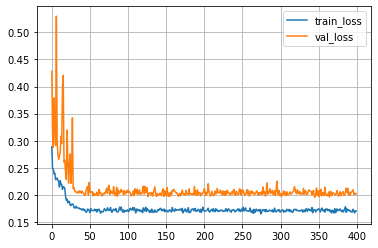

In [25]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing loss
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.show()

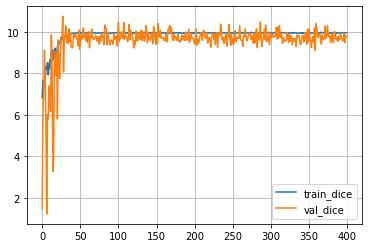

In [26]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing dice
    plt.plot(hist['dice'], label='train_dice')
    plt.plot(hist['val_dice'], label='val_dice')
    plt.legend()
    plt.grid()
    plt.show()

In [27]:
if not SEARCH_BS and not SEARCH_LR:
    sample_val_img, sample_val_mask = next(iter(dataloader['val']))
    one_sample_img = sample_val_img[0]
    one_sample_mask = sample_val_mask[0]

In [28]:
if not SEARCH_BS and not SEARCH_LR:
    def check_model(model, img, mask, type=''):
        model.eval()
        with torch.no_grad():
            img = img.unsqueeze(0).to(device)
            pred_mask = model(img)
            pred_mask = torch.argmax(pred_mask, axis=1)
            pred_mask = pred_mask.squeeze(0).type(torch.float32).detach().cpu().numpy()
            
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
        ax1.imshow(img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
        ax1.set_title('Image')
        ax2.imshow(torch.argmax(mask, axis=0).cpu().numpy())
        ax2.set_title('mask')
        ax3.imshow(pred_mask)
        ax3.set_title(f'pred_mask {type}')
        plt.show()

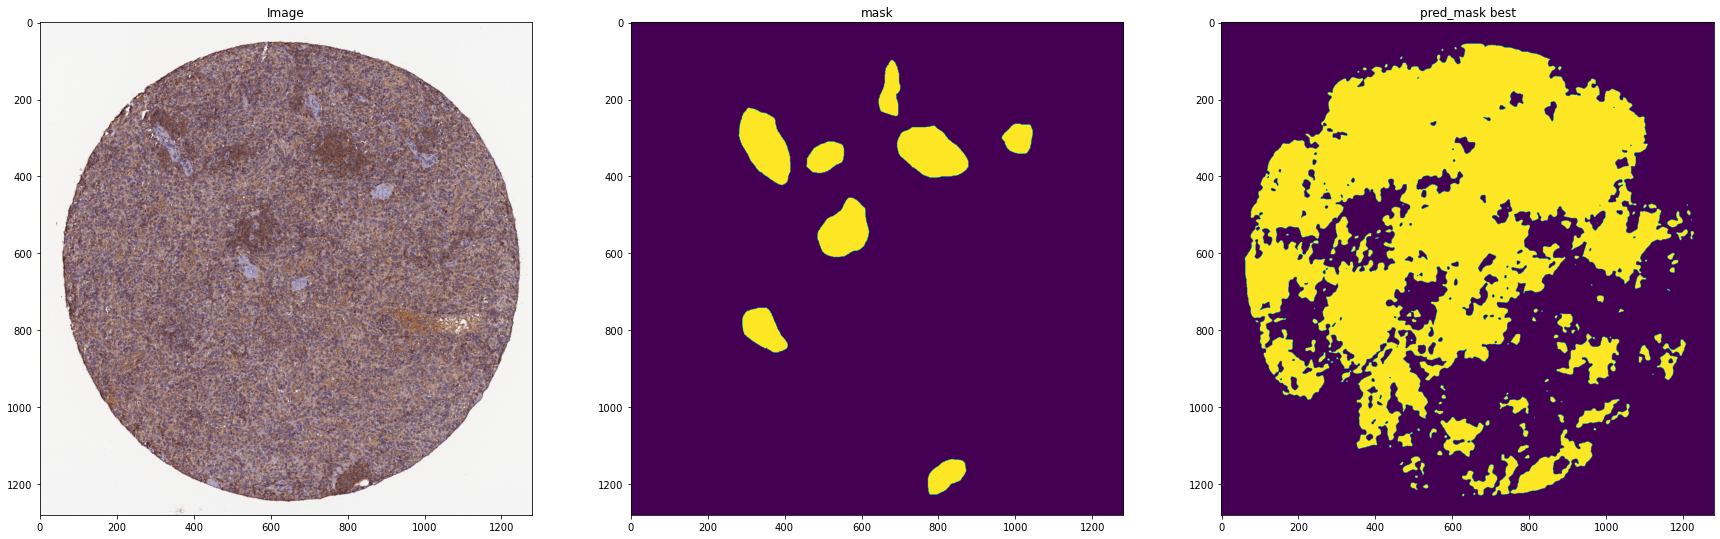

In [29]:
# Best model
if not SEARCH_BS and not SEARCH_LR:
    model = torch.load(path_best_model)
    check_model(model, one_sample_img, one_sample_mask, type='best')

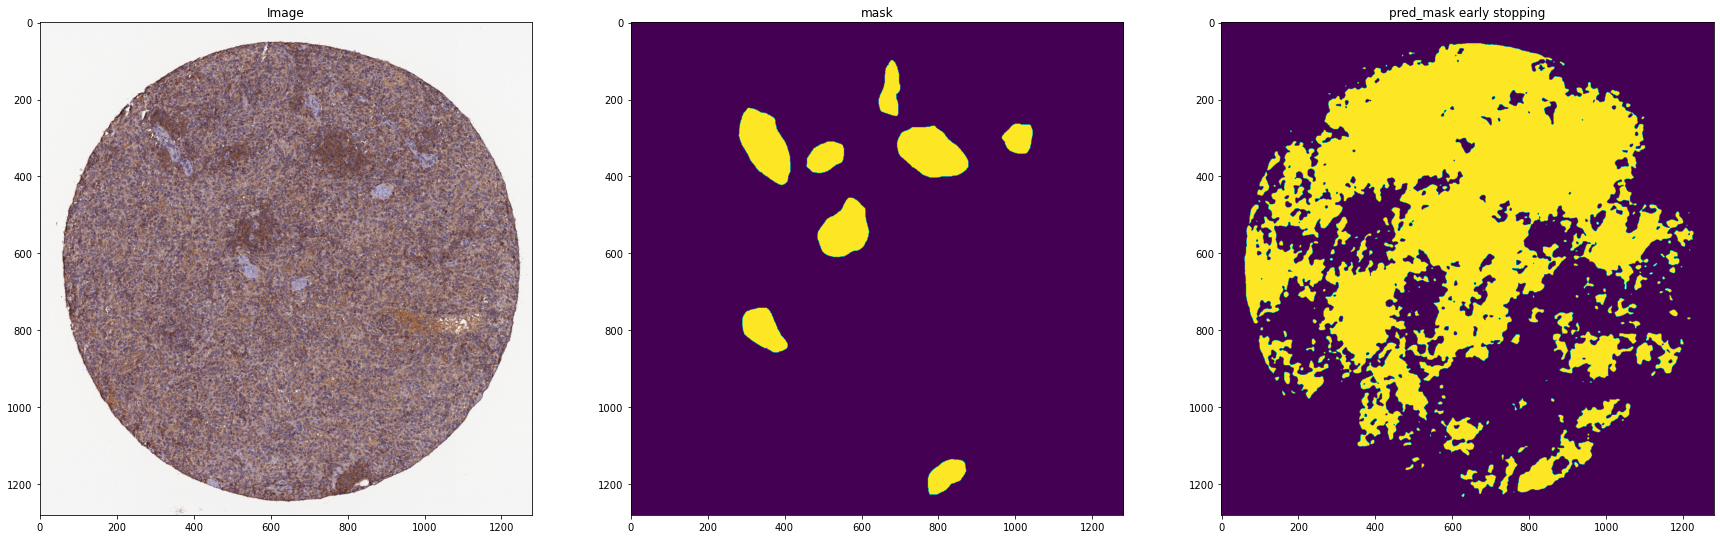

In [32]:
# Early stopping model
if not SEARCH_BS and not SEARCH_LR:
    model = torch.load(path_early_stopping_model)
    check_model(model, one_sample_img, one_sample_mask, type='early stopping')

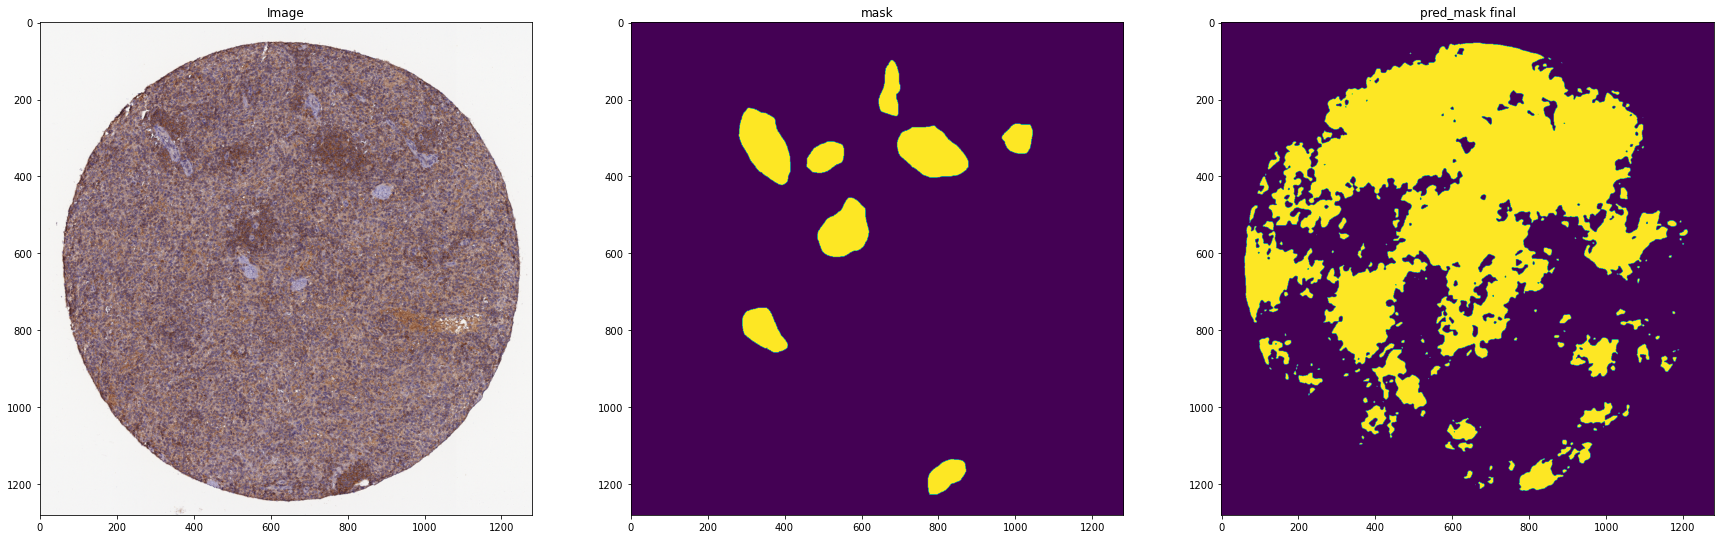

In [33]:
# Final stopping model
if not SEARCH_BS and not SEARCH_LR:
    model = torch.load(path_final_model)
    check_model(model, one_sample_img, one_sample_mask, type='final')